In [ ]:
%cd /content
!git clone https://github.com/arnavmdas/epiphany.git

/content
Cloning into 'epiphany'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 110 (delta 32), reused 69 (delta 17), pack-reused 6
Receiving objects: 100% (110/110), 30.62 KiB | 10.21 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
%%capture

##########################
#    Loading packages    #
##########################

# 1. Load packages

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import randn
from torch.nn import MSELoss
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import time
import pickle
from datetime import datetime
!pip install hickle
import hickle as hkl
from torch.autograd import Variable
import gzip
import sys
import os 
from sklearn.decomposition import TruncatedSVD, PCA
torch.set_default_tensor_type(torch.DoubleTensor)
!pip install pyBigWig
import pyBigWig

# 2. Load data - part 2

!wget https://s3.amazonaws.com/hicfiles.tc4ga.com/public/juicer/juicer_tools_1.22.01.jar
!wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/genes/hg38.refGene.gtf.gz
!gunzip /content/hg38.refGene.gtf.gz

chrom_list = ["chr"+str(i) for i in range(1,23)] #for human hg38
length_list = [248956422,242193529,198295559,190214555,181538259,170805979,159345973,145138636,
               138394717,133797422,135086622,133275309,114364328,107043718,101991189,90338345,
               83257441,80373285,58617616,64444167,46709983,50818468]
chrom_len_dict = dict(zip(chrom_list,length_list))

## Load pre-trained model 

The model is trained on GM12878 for 5kb resolution. 

In [ ]:
%cd /content/epiphany/downstream/utils
from model_architecture_util import * 

#Download pre-trained model parameters 
%cd /content/epiphany/
!mkdir pretrained
%cd pretrained
!wget -O pretrained_GM12878_5kb.pt_model https://wcm.box.com/shared/static/wo6bc6elqw0leivm7w9gnyte6sgos5om.pt_model

#Load model 
wsize = 14000
net = Net_wider(input_channels=5,window_size=wsize)
restore(net,'/content/epiphany/pretrained/pretrained_GM12878_5kb.pt_model')
net.eval()

/content/epiphany/downstream/utils
/content/epiphany
/content/epiphany/pretrained
--2022-10-10 19:09:25--  https://wcm.box.com/shared/static/wo6bc6elqw0leivm7w9gnyte6sgos5om.pt_model
Resolving wcm.box.com (wcm.box.com)... 74.112.186.144
Connecting to wcm.box.com (wcm.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/wo6bc6elqw0leivm7w9gnyte6sgos5om.pt_model [following]
--2022-10-10 19:09:26--  https://wcm.box.com/public/static/wo6bc6elqw0leivm7w9gnyte6sgos5om.pt_model
Reusing existing connection to wcm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://wcm.app.box.com/public/static/wo6bc6elqw0leivm7w9gnyte6sgos5om.pt_model [following]
--2022-10-10 19:09:27--  https://wcm.app.box.com/public/static/wo6bc6elqw0leivm7w9gnyte6sgos5om.pt_model
Resolving wcm.app.box.com (wcm.app.box.com)... 74.112.186.144
Connecting to wcm.app.box.com (wcm.app.box.com)|74.112.186.144|:443.

Net_wider(
  (conv1): ConvBlock(
    (conv): Conv1d(5, 70, kernel_size=(17,), stride=(1,))
    (act): ReLU()
    (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (do1): Dropout(p=0.1, inplace=False)
  (conv2): ConvBlock(
    (conv): Conv1d(70, 90, kernel_size=(7,), stride=(1,))
    (act): ReLU()
    (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (do2): Dropout(p=0.1, inplace=False)
  (conv3): ConvBlock(
    (conv): Conv1d(90, 70, kernel_size=(5,), stride=(1,))
    (act): ReLU()
    (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (do3): Dropout(p=0.1, inplace=False)
  (conv4): ConvBlock(
    (conv): Conv1d(70, 20, kernel_size=(5,), stride=(1,))
    (act): ReLU()
  )
  (pool): AdaptiveMaxPool1d(output_size=45)
  (do4): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(900, 2400, batch_first=True, bidirectional=True)
  (rnn2): LSTM(4800, 2400, batch_first=True, bidirection

## Download data

### Download input epigenomic data for H1ES cells (hg38)

In [ ]:
%cd /content/epiphany 
!mkdir bigWig
%cd bigWig 
!wget -O H1_CTCF_merge.bigWig https://wcm.box.com/shared/static/9kkjb6g3aemofepekbifn0xf8hi9r5rf.bigwig
!wget -O H1_DNaseI_merge.bigWig https://wcm.box.com/shared/static/0m0dy2r5hbb69juyf4obqogh0b5seuuj.bigwig 
!wget -O H1_H3K27ac_merge.bigWig https://wcm.box.com/shared/static/6sueimk61uylkc8t4b3uvgvtx8cbb7im.bigwig
!wget -O H1_H3K27me3_merge.bigWig https://wcm.box.com/shared/static/kyzfizvwevcv38rdwefln8jla6vndrxw.bigwig
!wget -O H1_H3K4me3_merge.bigWig https://wcm.box.com/shared/static/ci1tbr73tcp6hzknooedehoz4v4uth4a.bigwig

/content/epiphany
/content/epiphany/bigWig
--2022-10-10 19:12:10--  https://wcm.box.com/shared/static/9kkjb6g3aemofepekbifn0xf8hi9r5rf.bigwig
Resolving wcm.box.com (wcm.box.com)... 74.112.186.144
Connecting to wcm.box.com (wcm.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kkjb6g3aemofepekbifn0xf8hi9r5rf.bigwig [following]
--2022-10-10 19:12:10--  https://wcm.box.com/public/static/9kkjb6g3aemofepekbifn0xf8hi9r5rf.bigwig
Reusing existing connection to wcm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://wcm.app.box.com/public/static/9kkjb6g3aemofepekbifn0xf8hi9r5rf.bigwig [following]
--2022-10-10 19:12:11--  https://wcm.app.box.com/public/static/9kkjb6g3aemofepekbifn0xf8hi9r5rf.bigwig
Resolving wcm.app.box.com (wcm.app.box.com)... 74.112.186.144
Connecting to wcm.app.box.com (wcm.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting respons

### Extract epigenomic data from downloaded tracks

In [ ]:
%cd /content/epiphany/downstream/utils
from generate_predictions_util import *

input_tracks = data_load(chrom="chr8", bwfile_dir = "/content/epiphany/bigWig", distances=100, cell_type="H1")

/content/epiphany/downstream/utils


## Make prediction for with/without perturbation 

`prediction` function is loaded from [`generate_perturbations_util`](https://github.com/arnavmdas/epiphany/blob/main/downstream/utils/generate_perturbations_util.py): 

This function is used to generate perturbed/unperturbed region using pre-trained model. 

	'''
    chrom: which chromosome is of interest
	cell_type: cell type
	input_tracks: pre-loaded input tracks (output of `data_load` function)
	bin0, bin1: start and end location of the perturbation 
	perturb_type: [None,"mask", "deletion"]
	              - None: no perturbation is added onto the input signals. will generate original prediction for the region. 
				  - mask: signals in the perturbation area [bin0,bin1] in one or more epigenomic tracks got masked to the background
				  - deletion: signals in the perturbation area got deleted (deletion happens in all tracks)
	track_idxs: if perturb_type is "mask", signal on which track is masked 
				- 0 for DnaseI, 1 for H3K27ac, 2 for H3K4me3, 3 for H3K27me3, 4 for CTCF
				- can select one or more tracks, e.g. [4] or [0,4]
	save_txt: location for saving intermediate file 
	remap: whether to adjust the coordinates of deleted region. Only matters when perturb_type == "deletion".
	'''

In [ ]:
%cd /content/epiphany/downstream/utils
from generate_predictions_util import *

/content/epiphany/downstream/utils


In [ ]:
%cd /content/

#Select region of perturbation 
chrom = "chr8"
cell_type = "H1"
bin0, bin1 = 54165000, 54170000

#a) predict contact map of the region of interest without perturbation 
prediction(chrom,net,cell_type,input_tracks,bin0,bin1)
!java -Xms1024M -jar /content/juicer_tools_1.22.01.jar pre -d -c 8 -r 5000 -n -v /content/temp.txt.gz /content/temp_chr13.hic hg38

#b) predict contact map of the region of interest with perturbation: here we choose to delete the region 
prediction(chrom,net,cell_type,input_tracks,bin0,bin1,perturb_type="deletion")
!java -Xms1024M -jar /content/juicer_tools_1.22.01.jar pre -d -c 8 -r 5000 -n -v /content/temp.txt.gz /content/temp_perturbed_chr13.hic hg38

/content
WARN [2022-10-10T19:43:05,301]  [Globals.java:138] [main]  Development mode is enabled
Using 1 CPU thread(s)
Not including fragment map
Start preprocess
Writing header
Writing body
..
Writing footer

Finished preprocess

Calculating contact matrices took: 2080 milliseconds
Done creating .hic file. Normalization not calculated due to -n flag.
To run normalization, run: juicebox addNorm <hicfile>
WARN [2022-10-10T19:43:34,464]  [Globals.java:138] [main]  Development mode is enabled
Using 1 CPU thread(s)
Not including fragment map
Start preprocess
Writing header
Writing body
..
Writing footer

Finished preprocess

Calculating contact matrices took: 1819 milliseconds
Done creating .hic file. Normalization not calculated due to -n flag.
To run normalization, run: juicebox addNorm <hicfile>


## Visualization 

### Load additional packages 

In [ ]:
!pip install HiCExplorer
import hicexplorer

!pip install coolbox
!pip install cooltools
from cooltools.lib.numutils import set_diag
import coolbox
from coolbox.api import *
!jupyter nbextension enable --py widgetsnbextension
coolbox.__version__

!pip install pysam 
import pysam

!apt-get install tabix

!pip install bgzip
import bgzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 13.2 MB/s 
     |████████████████████████████████| 15.1 MB 71.2 MB/s 
     |████████████████████████████████| 235 kB 68.9 MB/s 
     |████████████████████████████████| 2.6 MB 67.0 MB/s 
     |████████████████████████████████| 829 kB 81.7 MB/s 
     |████████████████████████████████| 112 kB 75.4 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 115 kB 80.4 MB/s 
     |████████████████████████████████| 103 kB 53.2 MB/s 
     |████████████████████████████████| 1.6 MB 51.7 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 24.8 MB 71.6 MB/s 
     |████████████████████████████████| 10.1 MB 54.2 MB/s 
     |████████████████████████████████| 17.3 MB 44.9 MB/s 
     |████████████████████████████████| 12.5 MB 63.2 MB/s 
     |████████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.0 MB 10.4 MB/s 
     |████████████████████████████████| 112 kB 75.6 MB/s 
     |████████████████████████████████| 100 kB 2.8 MB/s 
     |████████████████████████████████| 475 kB 81.3 MB/s 
  Using cached simplejson-3.17.6-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (130 kB)
  Created wheel for cooltools: filename=cooltools-0.5.1-cp37-cp37m-linux_x86_64.whl size=367787 sha256=defb435b9f72d87cedd9b760d70c73ff05157db7a8823fe5fd683792e8ffa3ea
  Stored in directory: /root/.cache/pip/wheels/64/bb/0c/ef494ffaee115544bf383efd9a00b8564bd0ef37662b68ca64
  Created wheel for cytoolz: filename=cytoolz-0.10.1-cp37-cp37m-linux_x86_64.whl size=1238134 sha256=a8443fcaaa040deb772f3d1cde42aba488e7dc66befe5c66370bb43f096ef3e8
  Stored in directory: /root/.cache/pip/wheels/db/f0/a6/8d56aaec49585b245b0694bf8972e50a3b

### Visualization 

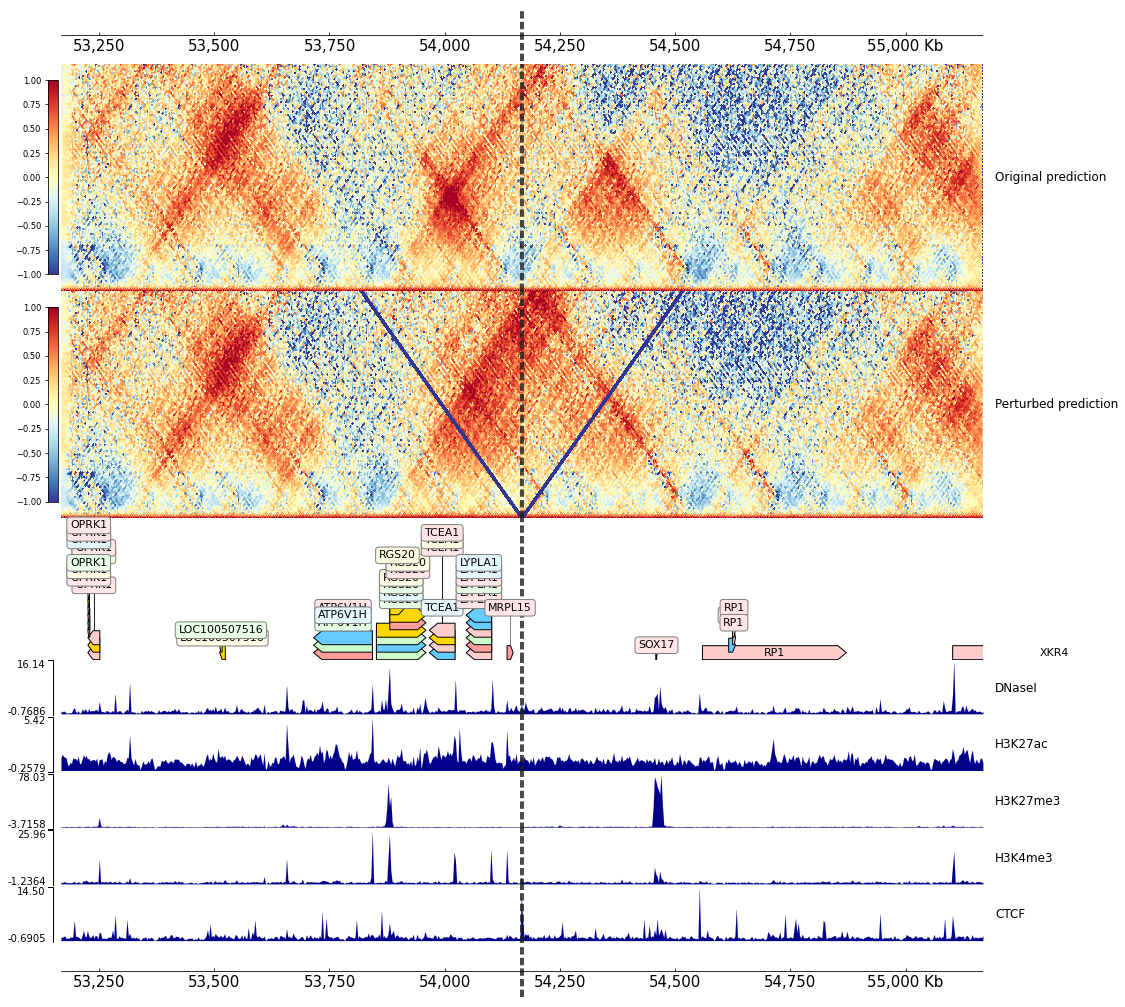

In [ ]:
chrom = "chr8"
cell_type = "H1"
bw_dnase = "/content/epiphany/bigWig/H1_DNaseI_merge.bigWig"
bw_h3k27ac = "/content/epiphany/bigWig/H1_H3K27ac_merge.bigWig"
bw_h3k27me3 = "/content/epiphany/bigWig/H1_H3K27me3_merge.bigWig"
bw_h3k4me3 = "/content/epiphany/bigWig/H1_H3K4me3_merge.bigWig"
bw_ctcf = "/content/epiphany/bigWig/H1_CTCF_merge.bigWig"
gtf_file = "/content/hg38.refGene.gtf" #if this track doesn't show up, try deleting intermediate files 

dot0 = HiCMat(f"/content/temp_chr13.hic",
              cmap="RdYlBu_r",depth_ratio=.5,resolution=5000,balance=False, gaussian_sigma=0.1) + \
              MinValue(-1) + MaxValue(1) + Title("Original prediction")
dot0p = HiCMat(f"/content/temp_perturbed_chr13.hic",
              cmap="RdYlBu_r",depth_ratio=.5,resolution=5000,balance=False, gaussian_sigma=0.1) + \
              MinValue(-1) + MaxValue(1) + Title("Perturbed prediction")

peak_width = bin1 - bin0
bin0new = int((bin0+bin1)/2-peak_width/2)
bin1new = int((bin0+bin1)/2+peak_width/2)
loci1 = [chrom+":"+str(int(bin0new))+"-"+str(int(bin1new))]

color = "darkblue"
frame = XAxis() + dot0 + dot0p + \
    GTF(gtf_file, row_filter=None, name_attribution="gene_name",height=5, length_ratio_thresh=0.001) + \
    BigWig(bw_dnase) + Title("DNaseI") + Color(color) + \
    BigWig(bw_h3k27ac) + Title("H3K27ac") + Color(color) + \
    BigWig(bw_h3k27me3) + Title("H3K27me3") + Color(color) + \
    BigWig(bw_h3k4me3) + Title("H3K4me3") + Color(color) + \
    BigWig(bw_ctcf) + Title("CTCF") + Color(color) + \
    XAxis()
# HiCDiff(dot0p,dot0,diff_method="diff") + \

frame *= Feature(depth_ratio=0.35)
frame *= Vlines(loci1,line_width=2)
idx_start = int((bin0+bin1)/2-1000000)
idx_end = int((bin0+bin1)/2+1000000)
frame.plot(chrom+":"+str(idx_start)+"-"+str(idx_end))
# frame.plot("chr8:53167500-55167500")